# Milestone Project 2: SkimLit 📝

Important papers:
* [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)
* [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)

The dataset can be downloaded from here: https://github.com/Franck-Dernoncourt/pubmed-rct

Tips from [George Hotz](https://www.twitch.tv/georgehotz), an ML engineer:

1. Download a paper.
2. Implement it.
3. Keep doing this until you have skills.
4. Build infrastructure around the model/data preprocessing steps.

## Get the Data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 17.59 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In [4]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/.ipynb_checkpoints']

## Preprocess the Data

In [1]:
def get_lines(filename):
    """Reads filename and returns the lines of text as a list.

    Args:
        filename (string): The target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

> The data representation:
```
[{
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11
}, ...]
```

In [2]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its content and sorts through each line,
    extracting items like the target label, the text of the sentence,
    the number of lines in the focused abstract and what sentence number
    the target line is.
    """
    input_lines = get_lines(filename)
    
    abstract_lines = ''
    abstract_samples = []

    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ''
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                target_text_split = abstract_line.split('\t')
                line_data = {
                    'target': target_text_split[0],
                    'text': target_text_split[1].lower(),
                    'line_number': abstract_line_number,
                    'total_lines': len(abstract_line_split) - 1
                }
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [10]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 408 ms, sys: 37.9 ms, total: 446 ms
Wall time: 449 ms


(180040, 30212, 30135)

In [11]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

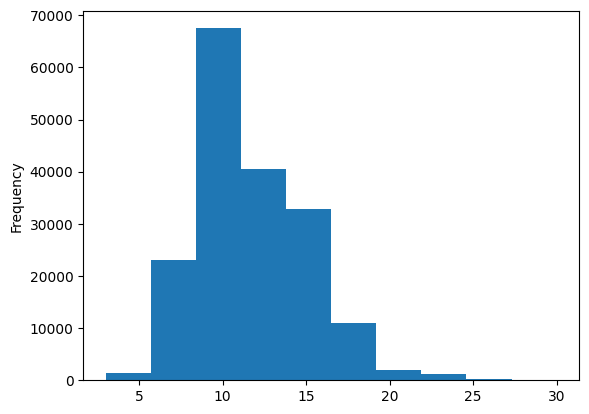

In [14]:
train_df.total_lines.plot.hist();

### Get Lists of Sentences

In [15]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making Numeric Labels

In [17]:
# One-hot encode the labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
# Label encode the labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from the LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Performing the Modelling Experiments

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Conv1D with token embeddings
* Model 2: Pre-trained Feature Extractor
* Model 3: Conv1D with character embeddings
* Model 4: Pre-trained token embeddings + character embeddings
* Model 5: Pre-trained token + character + positional embeddings

### Model 0: Get a Baseline

For reference, check out: https://chrisalbon.com/Home

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(
    X=train_sentences,
    y=train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(
    X=val_sentences,
    y=val_labels_encoded
)

0.7218323844829869

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download and Load the Helper Functions

The helper functions are available here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [3]:
from helper_functions import calculate_results

In [25]:
baseline_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the Data for Deep Sequence Models

In [4]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [27]:
# Get the average length of the sentences
np.mean([len(sentence.split()) for sentence in train_sentences])

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

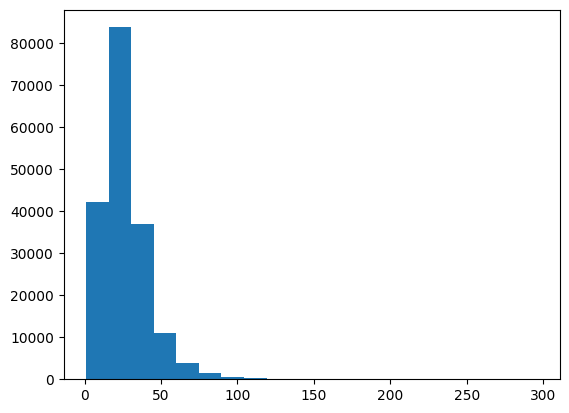

In [28]:
import matplotlib.pyplot as plt

plt.hist([len(sentence.split()) for sentence in train_sentences], bins=20)

In [29]:
# Check how long 95% of the sentences are
output_seq_len = int(np.percentile([
    len(sentence.split()) for sentence in train_sentences
], 95))

output_seq_len

55

For more information: https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

In [30]:
# Check the maximum sequence length in the training set
max([len(sentence.split()) for sentence in train_sentences])

296

#### Creating the Text Vectorization Layer

The vocabulary size of:

* PubMed 20k = 68k
* PubMed 200k = 331k

In [31]:
max_tokens = 68000    # PubMed 20k dataset

In [32]:
text_vectorization_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)

In [33]:
# Adapt text vectorizer to the training sentences
text_vectorization_layer.adapt(train_sentences)

In [34]:
# Test the text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)
print(f'Text:\n"{target_sentence}"')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text:\n{text_vectorization_layer([target_sentence])}')

Text:
"no major adverse occurrences , as defined by the study protocol , were reported from the acupuncture group although one woman found the needling uncomfortable , and no study participant experienced an increase in swelling of > @ % ."

Length of text: 40

Vectorized text:
[[   33   347   118 10639    25   472    22     2    17   402     9   205
     27     2   373    13   311    88  5942   208     2  2233 14331     3
     33    17  1276   581    26   179     5  3046     4     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# Check the number of words in the training vocabulary
rct_20k_text_vocab = text_vectorization_layer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in the vocabulary: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
text_vectorization_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Creating the Custom Token Embedding Layer

In [37]:
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name='token_embedding_layer'
)

In [38]:
print(f'Sentence before vectorization:\n"{target_sentence}"\n')
vectorized_sentence = text_vectorization_layer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
"no major adverse occurrences , as defined by the study protocol , were reported from the acupuncture group although one woman found the needling uncomfortable , and no study participant experienced an increase in swelling of > @ % ."

Sentence after vectorization (before embedding):
[[   33   347   118 10639    25   472    22     2    17   402     9   205
     27     2   373    13   311    88  5942   208     2  2233 14331     3
     33    17  1276   581    26   179     5  3046     4     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04512676  0.03001421 -0.01486202 ...  0.03721819 -0.01012977
    0.02893213]
  [ 0.02161742 -0.03582425  0.02320168 ... -0.03745623 -0.04014815
   -0.01405487]
  [ 0.00819992  0.01085467  0.00459565 ...  0.01568636 -0.02781228
    0.03034103]
  ...
  [-0.00416742 -0.00737026  0.04979238 ... -0.03042125 -0.03

### Creating Datasets (To Optimize Data Loads)

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.batch(32).prefetch(AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with Token Embeddings

In [41]:
inputs = layers.Input(shape=(1,), dtype='string', name='input_layer')
text_vectors = text_vectorization_layer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs, name='skimlit_model_1')

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy']
)

model_1.summary()

Model: "skimlit_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding_layer (Emb  (None, 55, 128)           8299648   
 edding)                                                         
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                   

In [42]:
history_1 = model_1.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 20s 34ms/step - loss: 0.9088 - accuracy: 0.6432 - val_loss: 0.6863 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.6606 - accuracy: 0.7550 - val_loss: 0.6349 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.6209 - accuracy: 0.7717 - val_loss: 0.5981 - val_accuracy: 0.7842


In [43]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6011 - accuracy: 0.7841


[0.6010958552360535, 0.7841255068778992]

In [44]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[3.9982113e-01, 1.8424201e-01, 9.8316647e-02, 2.8995404e-01,
         2.7666125e-02],
        [4.7359622e-01, 2.5149289e-01, 1.3472503e-02, 2.5408718e-01,
         7.3513086e-03],
        [1.4851484e-01, 6.7618061e-03, 2.4291840e-03, 8.4223133e-01,
         6.2731473e-05],
        ...,
        [2.5470897e-06, 5.9121393e-04, 6.7055126e-04, 2.4986134e-06,
         9.9873322e-01],
        [5.7062473e-02, 4.9798086e-01, 9.3497366e-02, 6.3608967e-02,
         2.8785038e-01],
        [1.9596368e-01, 6.3895798e-01, 5.2789725e-02, 4.6432666e-02,
         6.5855995e-02]], dtype=float32),
 (30212, 5))

In [45]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
model_1_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 78.41255130411757,
 'precision': 0.7808670153545283,
 'recall': 0.7841255130411757,
 'f1': 0.7817332386081248}

### Model 2: Feature Extraction with Pre-trained Token Embeddings

In [47]:
import tensorflow_hub as hub

use_embedding_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False,
    name='universal_sentence_encoder'
)

In [48]:
print(f'Random sentence:\n"{target_sentence}"\n')
use_embedded_sentence = use_embedding_layer([target_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence:
"no major adverse occurrences , as defined by the study protocol , were reported from the acupuncture group although one woman found the needling uncomfortable , and no study participant experienced an increase in swelling of > @ % ."

Sentence after embedding:
[ 0.00976055  0.05689659 -0.01213548 -0.05323793  0.01331824  0.06867745
  0.00219826 -0.04737353  0.06251882  0.0139769   0.04110466  0.00975517
  0.07796044 -0.04182032  0.01713898 -0.00628474 -0.059038   -0.05292323
  0.01741254 -0.03275552  0.04204125  0.04082135 -0.05894475  0.03975804
 -0.03804285  0.06350521 -0.01375526 -0.08300043  0.04403037 -0.03581662]

Length of sentence embedding: 512


In [49]:
inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')
pretrained_embedding = use_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs, name='skimlit_model_2')

model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy']
)

model_2.summary()

Model: "skimlit_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [50]:
history_2 = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 7s 7ms/step - loss: 0.9181 - accuracy: 0.6493 - val_loss: 0.7972 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7685 - accuracy: 0.7009 - val_loss: 0.7553 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.7523 - accuracy: 0.7116 - val_loss: 0.7392 - val_accuracy: 0.7118


In [51]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.7413 - accuracy: 0.7136


[0.7413352727890015, 0.7135906219482422]

In [52]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 7s 7ms/step


array([[3.9683256e-01, 4.0370589e-01, 3.0042632e-03, 1.8602107e-01,
        1.0436178e-02],
       [3.6283866e-01, 4.8454598e-01, 4.2573549e-03, 1.4452705e-01,
        3.8309181e-03],
       [2.1394895e-01, 1.4853211e-01, 1.9879324e-02, 5.7625687e-01,
        4.1382689e-02],
       ...,
       [1.7372982e-03, 5.4209293e-03, 4.7305427e-02, 7.7106443e-04,
        9.4476533e-01],
       [4.3288190e-03, 5.2967250e-02, 1.9983472e-01, 1.2534080e-03,
        7.4161583e-01],
       [1.9436978e-01, 2.5495291e-01, 4.7211781e-01, 9.5221465e-03,
        6.9037281e-02]], dtype=float32)

In [53]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [54]:
model_2_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_preds
)
model_2_results

{'accuracy': 71.35906262412286,
 'precision': 0.714066349187408,
 'recall': 0.7135906262412286,
 'f1': 0.7106895430119391}

### Model 3: Conv1D with Character Embeddings

#### Creating the Character Vectorization Layer

In [23]:
def split_chars(text):
    """Splits the text and returns its characters.
    """
    return ' '.join(list(text))

In [56]:
split_chars(target_sentence)

'n o   m a j o r   a d v e r s e   o c c u r r e n c e s   ,   a s   d e f i n e d   b y   t h e   s t u d y   p r o t o c o l   ,   w e r e   r e p o r t e d   f r o m   t h e   a c u p u n c t u r e   g r o u p   a l t h o u g h   o n e   w o m a n   f o u n d   t h e   n e e d l i n g   u n c o m f o r t a b l e   ,   a n d   n o   s t u d y   p a r t i c i p a n t   e x p e r i e n c e d   a n   i n c r e a s e   i n   s w e l l i n g   o f   >   @   %   .'

In [57]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
# Get the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

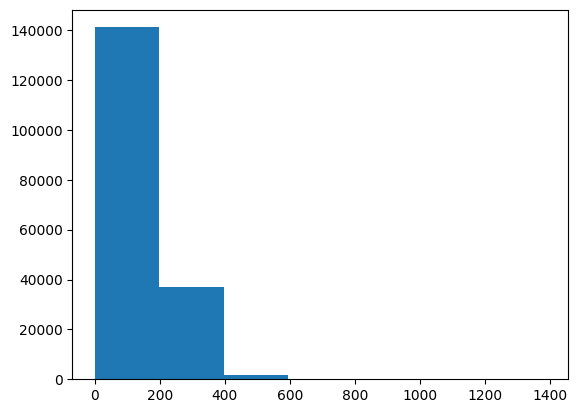

In [59]:
# Check the distribution of the sequence at a character-level
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=7)

In [60]:
# Check the length of the 95th percentile of the sequences
output_seq_char_len =  int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [61]:
import string

alphabet = string.ascii_lowercase + string.digits
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [62]:
NUM_CHAR_TOKENS = len(alphabet) + 2    # Add space and the <OOV> token

char_vectorization_layer = layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name='char_vectorization_layer'
)

In [63]:
char_vectorization_layer.adapt(train_chars)

In [64]:
char_vocab = char_vectorization_layer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [65]:
random_train_char = random.choice(train_chars)
print(f'Charified text (length={len(random_train_char.split())}):\n"{random_train_char}"\n')

vectorized_chars = char_vectorization_layer([random_train_char])
print(f'Vectorized chars (length={len(vectorized_chars[0])}):\n{vectorized_chars}')

Charified text (length=58):
"t o   c o m p a r e   c l o s e d - s y s t e m   (   c o s   )   p i v c s   w i t h   o p e n - s y s t e m   (   m o s   )   p i v c s   ."

Vectorized chars (length=290):
[[ 3  7 11  7 15 14  5  8  2 11 12  7  9  2 10  9 19  9  3  2 15 11  7  9
  14  4 21 11  9 20  4  3 13  7 14  2  6  9 19  9  3  2 15 15  7  9 14  4
  21 11  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

#### Creating the Character-Level Embeddings

In [66]:
char_embed = layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,    # Size of the character embeddings in the paper
    mask_zero=True,
    name='char_embed'
)

In [67]:
char_embed_example = char_embed(vectorized_chars)
char_embed_example, char_embed_example.shape

(<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
 array([[[ 0.00253403,  0.02663866,  0.03468734, ..., -0.00217485,
          -0.04192872,  0.02068874],
         [-0.00251464,  0.00207957,  0.00316826, ..., -0.0388535 ,
           0.00987913, -0.0237473 ],
         [-0.03238677, -0.02183094, -0.00495323, ..., -0.02811427,
           0.01214734, -0.0326633 ],
         ...,
         [ 0.02186443,  0.01102876, -0.03784069, ..., -0.04768609,
           0.03250076, -0.04042744],
         [ 0.02186443,  0.01102876, -0.03784069, ..., -0.04768609,
           0.03250076, -0.04042744],
         [ 0.02186443,  0.01102876, -0.03784069, ..., -0.04768609,
           0.03250076, -0.04042744]]], dtype=float32)>,
 TensorShape([1, 290, 25]))

#### Building the Conv1D Model

In [68]:
inputs = layers.Input(shape=(1,), dtype='string', name='input_layer')
char_vectors = char_vectorization_layer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name='skimlit_model_3')

model_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy']
)

model_3.summary()

Model: "skimlit_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorization_layer (  (None, 290)               0         
 TextVectorization)                                              
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 output_layer (Dense)        (None, 5)             

In [69]:
# Create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((
    train_chars,
    train_labels_one_hot
)).batch(32).prefetch(AUTOTUNE)

valid_char_dataset = tf.data.Dataset.from_tensor_slices((
    val_chars,
    val_labels_one_hot
)).batch(32).prefetch(AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices((
    test_chars,
    test_labels_one_hot
)).batch(32).prefetch(AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [70]:
history_3 = model_3.fit(
    train_char_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    validation_data=valid_char_dataset,
    validation_steps=int(0.1 * len(valid_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 1.2604 - accuracy: 0.4909 - val_loss: 1.0475 - val_accuracy: 0.5778
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0170 - accuracy: 0.5946 - val_loss: 0.9546 - val_accuracy: 0.6187
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9412 - accuracy: 0.6295 - val_loss: 0.8893 - val_accuracy: 0.6486


In [71]:
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.9035 - accuracy: 0.6464


[0.903527557849884, 0.6464318633079529]

In [72]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.169593  , 0.35774806, 0.13869755, 0.2704683 , 0.0634931 ],
       [0.1282455 , 0.6668355 , 0.01464869, 0.1173723 , 0.072898  ],
       [0.09550262, 0.2430917 , 0.15669858, 0.46794105, 0.0367661 ],
       ...,
       [0.01608845, 0.04447899, 0.2105057 , 0.05743901, 0.67148787],
       [0.0283309 , 0.13998981, 0.3057556 , 0.02674079, 0.49918297],
       [0.5413106 , 0.27118242, 0.08441819, 0.08852147, 0.01456728]],
      dtype=float32)

In [73]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [74]:
model_3_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_3_preds
)
model_3_results

{'accuracy': 64.64318813716405,
 'precision': 0.6367235846451026,
 'recall': 0.6464318813716404,
 'f1': 0.6363962415174074}

### Model 4: Pre-trained Token Embeddings + Character Embeddings

1. Create a token-level embedding model (same as `model_1`).
2. Create a character-level embedding model (same as `model_3`).
3. Combine (1) and (2) with a `Concatenate` layer.
4. Build a series of output layers on top of (3).
5. Construct a model which takes:
    - Token and character-level sequences as inputs.
    - Produces sequence label probabilities as output.

For more information:
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

In [75]:
token_inputs = layers.Input(shape=[], dtype='string', name='token_input')
token_embeddings = use_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu', name='token_output')(token_embeddings)
token_model = tf.keras.Model(
    inputs=token_inputs,
    outputs=token_outputs,
    name='skimlit_token_model_4'
)

char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectors = char_vectorization_layer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(
    inputs=char_inputs,
    outputs=char_bi_lstm,
    name='skimlit_char_model_4'
)

token_char_concat = layers.Concatenate(name='token_char_hybrid')([
    token_model.output,
    char_model.output
])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_dropout)

model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name='skimlit_model_4'
)

In [76]:
model_4.summary()

Model: "skimlit_model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorization_layer (  (None, 290)                  0         ['char_input[0][0]']          
 TextVectorization)                                                                               
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0]

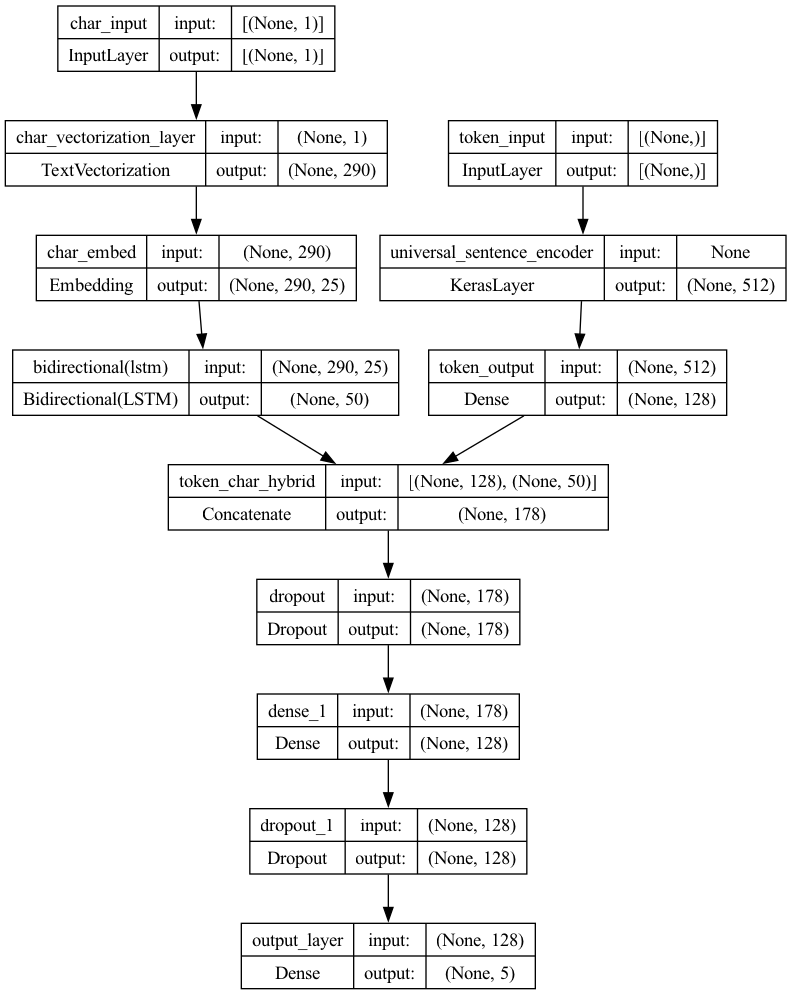

In [78]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [80]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy']
)

In [81]:
# Combine the char and token datasets
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(AUTOTUNE)

valid_char_token_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)),
    tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

test_char_token_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)),
    tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

train_char_token_dataset, valid_char_token_dataset, test_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:
history_4 = model_4.fit(
    train_char_token_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    validation_data=valid_char_token_dataset,
    validation_steps=int(0.1 * len(valid_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 56s 88ms/step - loss: 0.9879 - accuracy: 0.6086 - val_loss: 0.7840 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 48s 85ms/step - loss: 0.8034 - accuracy: 0.6913 - val_loss: 0.7174 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 52s 93ms/step - loss: 0.7762 - accuracy: 0.7048 - val_loss: 0.6932 - val_accuracy: 0.7367


In [83]:
model_4_pred_probs = model_4.predict(valid_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 20ms/step


array([[5.0410950e-01, 3.1377178e-01, 4.4499342e-03, 1.7263351e-01,
        5.0353431e-03],
       [3.3907378e-01, 4.6669513e-01, 2.2849280e-03, 1.9022541e-01,
        1.7207183e-03],
       [3.0912268e-01, 9.3267873e-02, 3.7505489e-02, 5.4382253e-01,
        1.6281433e-02],
       ...,
       [5.6469423e-04, 1.0977191e-02, 6.0052466e-02, 2.3017080e-04,
        9.2817551e-01],
       [1.0592522e-02, 7.4236996e-02, 2.5179678e-01, 4.9821525e-03,
        6.5839159e-01],
       [2.7327421e-01, 3.6091223e-01, 2.7498618e-01, 3.1280845e-02,
        5.9546545e-02]], dtype=float32)

In [86]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [87]:
model_4_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)
model_4_results

{'accuracy': 73.43439692837283,
 'precision': 0.7338149116564285,
 'recall': 0.7343439692837284,
 'f1': 0.7322430150251856}

### Model 5: Pre-trained Token + Character + Positional Embeddings

Positional embeddings can be added via feature engineering, by grouping non-obvious features from the data and encoding them numerically to help the model learn.

Examples of feature engineering techniques:

* Imputation
* Discretization
* Categorical encoding
* Data augmentation
* Feature spilitting
* Outlier handling
* Scaling and standardisation

In [88]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


#### Creating Positional Embeddings

In [89]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

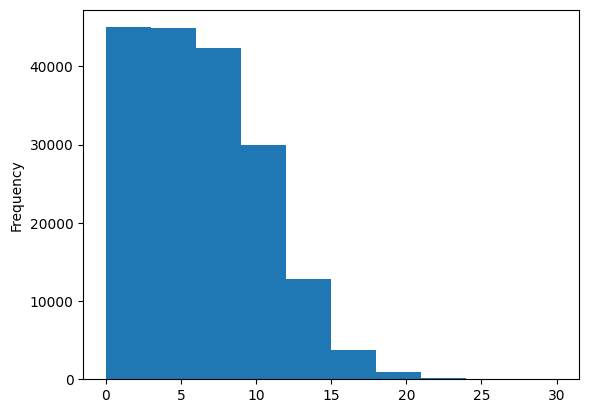

In [90]:
train_df.line_number.plot.hist()

In [100]:
np.percentile(train_df['line_number'], 95)

13.0

In [95]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [96]:
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

val_line_numbers_one_hot.shape, test_line_numbers_one_hot.shape

(TensorShape([30212, 15]), TensorShape([30135, 15]))

In [97]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

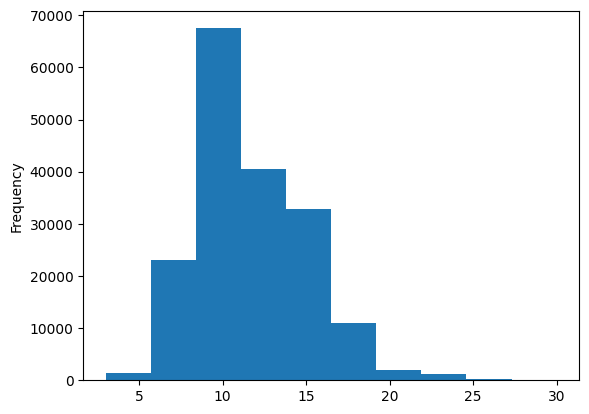

In [98]:
train_df.total_lines.plot.hist()

In [99]:
np.percentile(train_df['total_lines'], 95)

18.0

In [102]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:5]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

#### Building the Tribrid Embedding Model

1. Create a token-level model.
2. Create a character-level model.
3. Create a model for the `line_number` feature.
4. Create a model for the `total_lines` feature.
5. Combine the outputs of (1) and (2) with `Concatenate`.
6. Combine the outputs (3), (4) and (5) with `Concatenate`.
7. Create an output layer to accept the tribrid embeddings and output label probabilities.
8. Combine the inputs of (1), (2), (3) and (4) and outputs into a `tf.keras.Model`.

In [103]:
# 1. The token-level model
token_inputs = layers.Input(shape=[], dtype='string', name='token_input')
token_embeddings = use_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(
    inputs=token_inputs,
    outputs=token_outputs
)

# 2. The character-level model
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectors = char_vectorization_layer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(
    inputs=char_inputs,
    outputs=char_bi_lstm
)

# 3. The line-number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(
    inputs=line_number_inputs,
    outputs=x
)

# 4. The total-lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(
    inputs=total_lines_inputs,
    outputs=y
)

# 5. Concatenate (1) and (2)
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embeddings')([
    token_model.output,
    char_model.output
])

# 5.1 Pass the character-token embeddings through a dropout layer
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Concatenate (3), (4) and (5)
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embeddings')([
    line_number_model.output,
    total_lines_model.output,
    z
])

# 7. The final output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. The tribrid model
model_5 = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    outputs=output_layer,
    name='skimlit_model_5'
)

In [104]:
model_5.summary()

Model: "skimlit_model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorization_layer (  (None, 290)                  0         ['char_input[0][0]']          
 TextVectorization)                                                                               
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0]

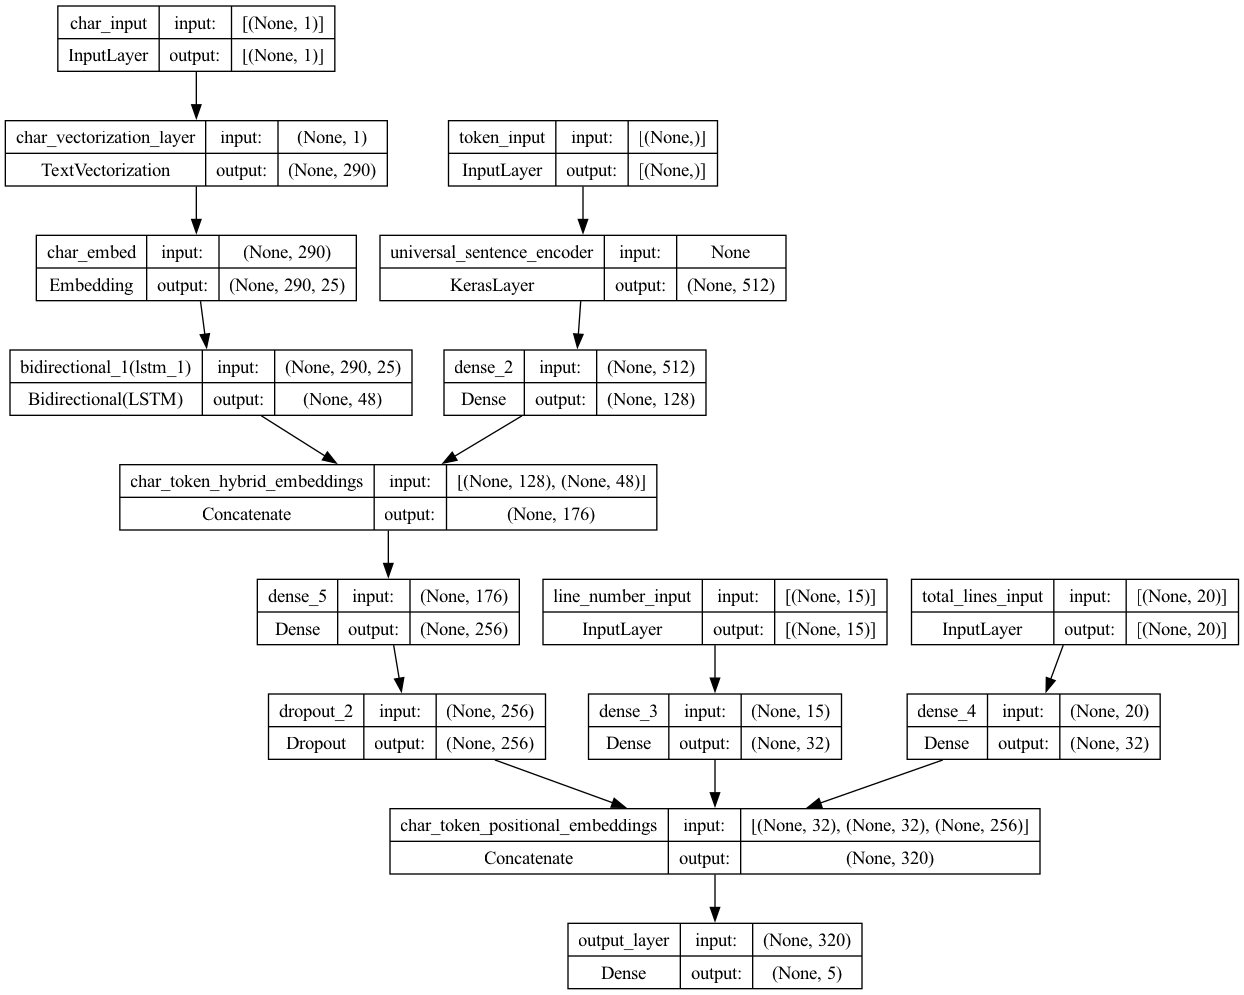

In [105]:
tf.keras.utils.plot_model(model_5, to_file='skimlit_model_5.png', show_shapes=True)

In [106]:
# 9. Compile the token + char + positional embedding model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy']
)

> For more on label smoothing: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

#### Creating the Tribrid Embedding Datasets

In [107]:
train_tribrid_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        train_line_numbers_one_hot,
        train_total_lines_one_hot,
        train_sentences,
        train_chars
    )),
    tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

valid_tribrid_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        val_line_numbers_one_hot,
        val_total_lines_one_hot,
        val_sentences,
        val_chars
    )),
    tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

test_tribrid_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        test_line_numbers_one_hot,
        test_total_lines_one_hot,
        test_sentences,
        test_chars
    )),
    tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

train_tribrid_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Fitting the Tribrid Model

In [108]:
history_5 = model_5.fit(
    train_tribrid_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_tribrid_dataset)),
    validation_data=valid_tribrid_dataset,
    validation_steps=int(0.1 * len(valid_tribrid_dataset))
)

Epoch 1/3
562/562 [==============================] - 55s 87ms/step - loss: 1.1071 - accuracy: 0.7171 - val_loss: 0.9821 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 45s 80ms/step - loss: 0.9687 - accuracy: 0.8138 - val_loss: 0.9514 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 47s 84ms/step - loss: 0.9513 - accuracy: 0.8241 - val_loss: 0.9421 - val_accuracy: 0.8288


In [109]:
model_5_pred_probs = model_5.predict(valid_tribrid_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 20ms/step


array([[0.50284016, 0.11095677, 0.00918146, 0.3605205 , 0.0165011 ],
       [0.5537837 , 0.10245509, 0.03985364, 0.2933568 , 0.0105507 ],
       [0.2922519 , 0.09117708, 0.11021468, 0.44066614, 0.0656902 ],
       ...,
       [0.04003962, 0.10741596, 0.05043951, 0.03685592, 0.7652491 ],
       [0.03078633, 0.27761498, 0.08448258, 0.03047094, 0.57664514],
       [0.17564893, 0.6046672 , 0.10933894, 0.04445126, 0.06589372]],
      dtype=float32)

In [110]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
model_5_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_5_preds
)
model_5_results

{'accuracy': 83.17224943730967,
 'precision': 0.8312502211907868,
 'recall': 0.8317224943730968,
 'f1': 0.8308620090769324}

### Comparing the Model Results

In [113]:
model_results = pd.DataFrame({
    'model_0_baseline': baseline_results,
    'model_1_custom_token_embeddings': model_1_results,
    'model_2_pretrained_token_embeddings': model_2_results,
    'model_3_custom_char_embeddings': model_3_results,
    'model_4_hybrid_char_token_embeddings': model_4_results,
    'model_5_tribrid_char_token_pos_embeddings': model_5_results
})
model_results = model_results.transpose()
model_results['accuracy'] = model_results['accuracy'] / 100
model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embeddings,0.784126,0.780867,0.784126,0.781733
model_2_pretrained_token_embeddings,0.713591,0.714066,0.713591,0.710690
model_3_custom_char_embeddings,0.646432,0.636724,0.646432,0.636396
model_4_hybrid_char_token_embeddings,0.734344,0.733815,0.734344,0.732243
model_5_tribrid_char_token_pos_embeddings,0.831722,0.831250,0.831722,0.830862


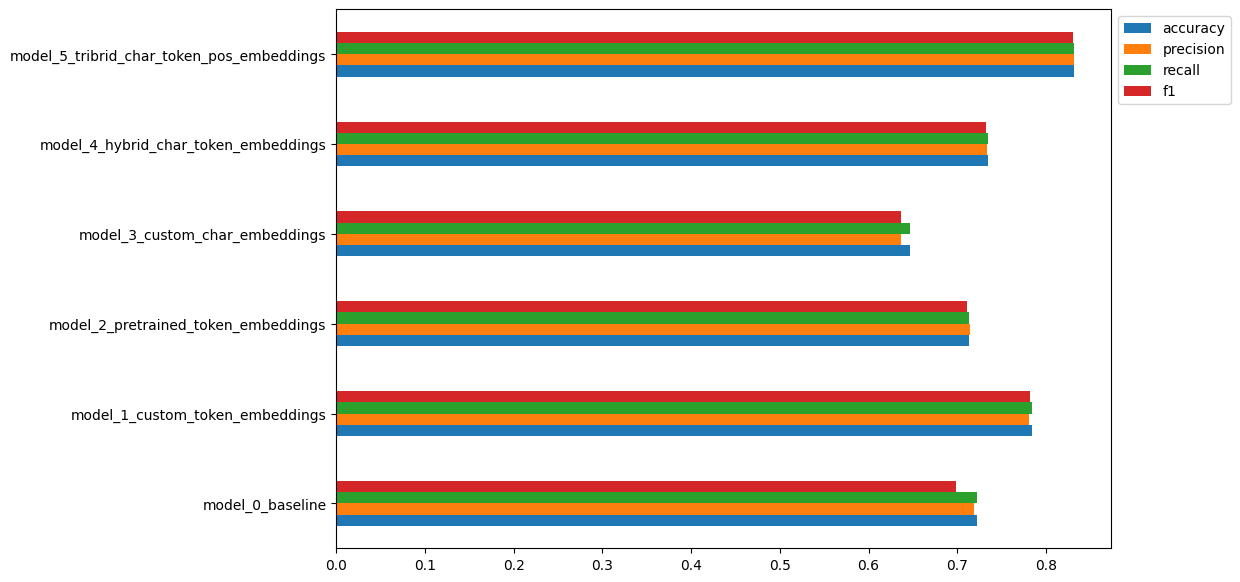

In [114]:
model_results.plot(kind='barh', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

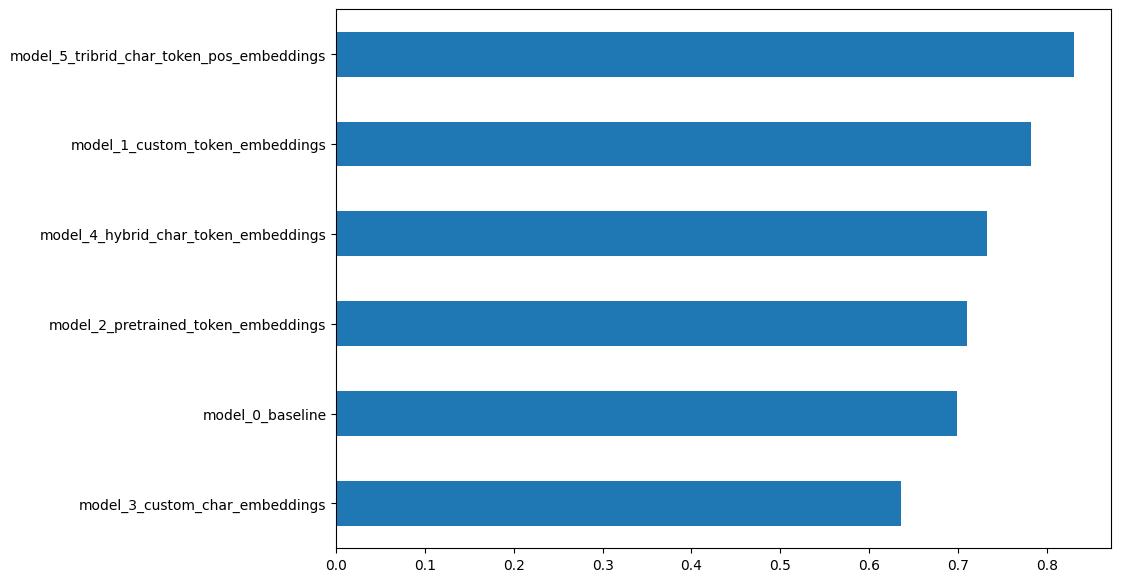

In [115]:
model_results.sort_values('f1')['f1'].plot(kind='barh', figsize=(10, 7));

## Working with the PubMed 200k RCT Dataset

In [5]:
data_dir = 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [119]:
!unzip 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip'

Archive:  pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: train.txt               


In [120]:
!mv 'train.txt' 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [6]:
import tensorflow

from tensorflow import keras
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras import layers

### Preparing the Datasets

In [7]:
import pandas as pd

# Create the dataframes
train_df = pd.DataFrame(preprocess_text_with_line_numbers(data_dir + 'train.txt'))
val_df = pd.DataFrame(preprocess_text_with_line_numbers(data_dir + 'dev.txt'))
test_df = pd.DataFrame(preprocess_text_with_line_numbers(data_dir + 'test.txt'))

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


In [8]:
len(train_df), len(val_df), len(test_df)

(2211861, 28932, 29493)

In [9]:
train_df['target'].value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

In [10]:
# Collect the sample labels and encode them
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [11]:
# Collect the sample sentences
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

# One-hot encode the labels
train_labels_one_hot = tf.one_hot(train_labels_encoded, depth=5)
val_labels_one_hot = tf.one_hot(val_labels_encoded, depth=5)
test_labels_one_hot = tf.one_hot(test_labels_encoded, depth=5)

train_labels_one_hot

<tf.Tensor: shape=(2211861, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [12]:
train_df.line_number.value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: line_number, dtype: int64

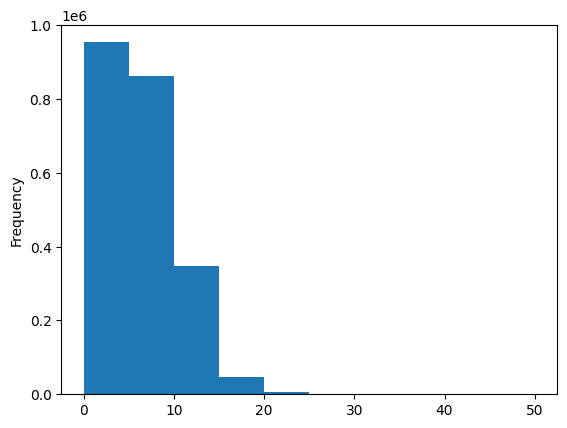

In [13]:
train_df.line_number.plot.hist();

In [14]:
import numpy as np

np.percentile(train_df['line_number'], 95)

13.0

In [15]:
# Collect the line_numbers and one-hot encode them
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot

<tf.Tensor: shape=(2211861, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [16]:
train_df.total_lines.value_counts()

10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: total_lines, dtype: int64

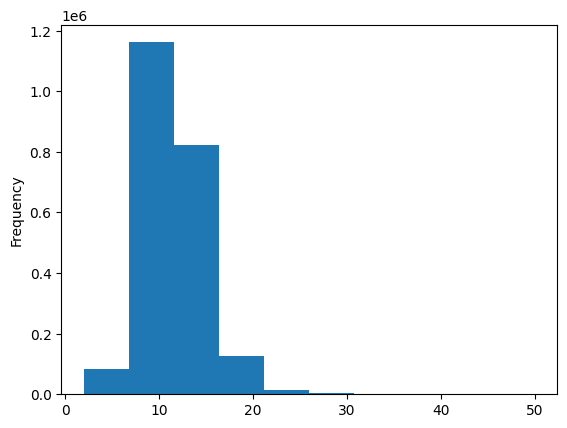

In [17]:
train_df.total_lines.plot.hist();

In [18]:
np.percentile(train_df['total_lines'], 95)

17.0

In [19]:
# Collect the total_lines and one-hot encode them
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot

<tf.Tensor: shape=(2211861, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [24]:
# Create the character sets
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [25]:
np.percentile([len(sentence) for sentence in train_sentences], 95)

284.0

In [26]:
# Create the datasets and prefetch them
from tensorflow.data import Dataset, AUTOTUNE

train_dataset = Dataset.zip((
    Dataset.from_tensor_slices((
        train_line_numbers_one_hot,
        train_total_lines_one_hot,
        train_sentences,
        train_chars
    )),
    Dataset.from_tensor_slices(train_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

valid_dataset = Dataset.zip((
    Dataset.from_tensor_slices((
        val_line_numbers_one_hot,
        val_total_lines_one_hot,
        val_sentences,
        val_chars
    )),
    Dataset.from_tensor_slices(val_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

test_dataset = Dataset.zip((
    Dataset.from_tensor_slices((
        test_line_numbers_one_hot,
        test_total_lines_one_hot,
        test_sentences,
        test_chars
    )),
    Dataset.from_tensor_slices(test_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### Creating the Token Embeddings

In [28]:
train_sentences[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

In [27]:
len(train_sentences)

2211861

In [25]:
np.percentile([
    len(sentence.split()) for sentence in train_sentences
], 95)

54.0

In [37]:
train_token_dataset = Dataset.from_tensor_slices(train_sentences).batch(32).prefetch(AUTOTUNE)
train_token_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [33]:
token_vectorizer = layers.TextVectorization(
    max_tokens=331000,
    output_sequence_length=54
)

In [38]:
%%time
token_vectorizer.adapt(
    train_token_dataset,
    batch_size=32,
    steps=int(0.1 * len(train_token_dataset))
)

CPU times: user 4 s, sys: 270 ms, total: 4.27 s
Wall time: 3.73 s


In [39]:
rct_200k_token_vocab = token_vectorizer.get_vocabulary()

In [40]:
token_embed = layers.Embedding(
    input_dim=len(rct_200k_token_vocab),
    output_dim=128,
    mask_zero=True,
    name='token_embedding_layer'
)

### Creating the Character Embeddings

In [31]:
test_chars[:5]

['m a n y   p a t h o g e n i c   p r o c e s s e s   a n d   d i s e a s e s   a r e   t h e   r e s u l t   o f   a n   e r r o n e o u s   a c t i v a t i o n   o f   t h e   c o m p l e m e n t   c a s c a d e   a n d   a   n u m b e r   o f   i n h i b i t o r s   o f   c o m p l e m e n t   h a v e   t h u s   b e e n   e x a m i n e d   f o r   a n t i - i n f l a m m a t o r y   a c t i o n s   .',
 'i t   w a s   r e c e n t l y   d e m o n s t r a t e d   t h a t   s u p r a p h y s i o l o g i c a l   c o n c e n t r a t i o n s   o f   t h e   e n d o g e n o u s   c o m p l e m e n t   i n h i b i t o r   m a p @   (   a l s o   d e n o t e d   m a p @   )   p r o t e c t   a g a i n s t   m y o c a r d i a l   r e p e r f u s i o n   i n j u r y   .',
 'i n   t h e   p r e s e n t   s t u d y   ,   w e   e x a m i n e d   t h e   a s s o c i a t i o n   b e t w e e n   o u t c o m e   a f t e r   a c u t e   m y o c a r d i a l   i n f a r c t i o n   (   m i   )   a n d 

In [30]:
len(test_chars)

29493

In [41]:
train_char_dataset = Dataset.from_tensor_slices(train_chars).batch(32).prefetch(AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [29]:
import string

string.ascii_lowercase + string.digits

'abcdefghijklmnopqrstuvwxyz0123456789'

In [42]:
char_vectorizer = layers.TextVectorization(
    max_tokens=len(string.ascii_letters + string.digits) + 2,
    output_sequence_length=284
)

In [43]:
%%time
char_vectorizer.adapt(
    train_char_dataset,
    batch_size=32,
    steps=int(0.1 * len(train_char_dataset))
)

CPU times: user 4.55 s, sys: 319 ms, total: 4.87 s
Wall time: 4.32 s


In [44]:
rct_200k_char_vocab = char_vectorizer.get_vocabulary()

In [45]:
char_embed = layers.Embedding(
    input_dim=len(rct_200k_char_vocab),
    output_dim=24,
    mask_zero=True,
    name='char_embedding_layer'
)

### Building the Large Model

In [50]:
num_classes = len(set(train_labels_encoded))
num_classes

5

In [64]:
token_inputs = layers.Input(shape=(1,), dtype='string', name='token_input')
token_vectors = token_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
a = layers.Dense(128, activation='relu')(token_embeddings)
a = layers.Dense(32, activation='relu')(a)
a = layers.GlobalMaxPool1D()(a)
token_model = tf.keras.Model(inputs=token_inputs, outputs=a)

char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
b = layers.Dense(32, activation='relu')(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs, outputs=b)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

combined_embeddings = layers.Concatenate(name='hybrid_char_token_embeddings')([
    token_model.output,
    char_model.output
])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name='tribrid_char_token_pos_embeddings')([
    line_number_model.output,
    total_lines_model.output,
    z
])

output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

model_large = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    outputs=output_layer,
    name='skimlit_large_model'
)

model_large.summary()

Model: "skimlit_large_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 54)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding_layer (Emb  (None, 54, 128)              8924416   ['text_vecto

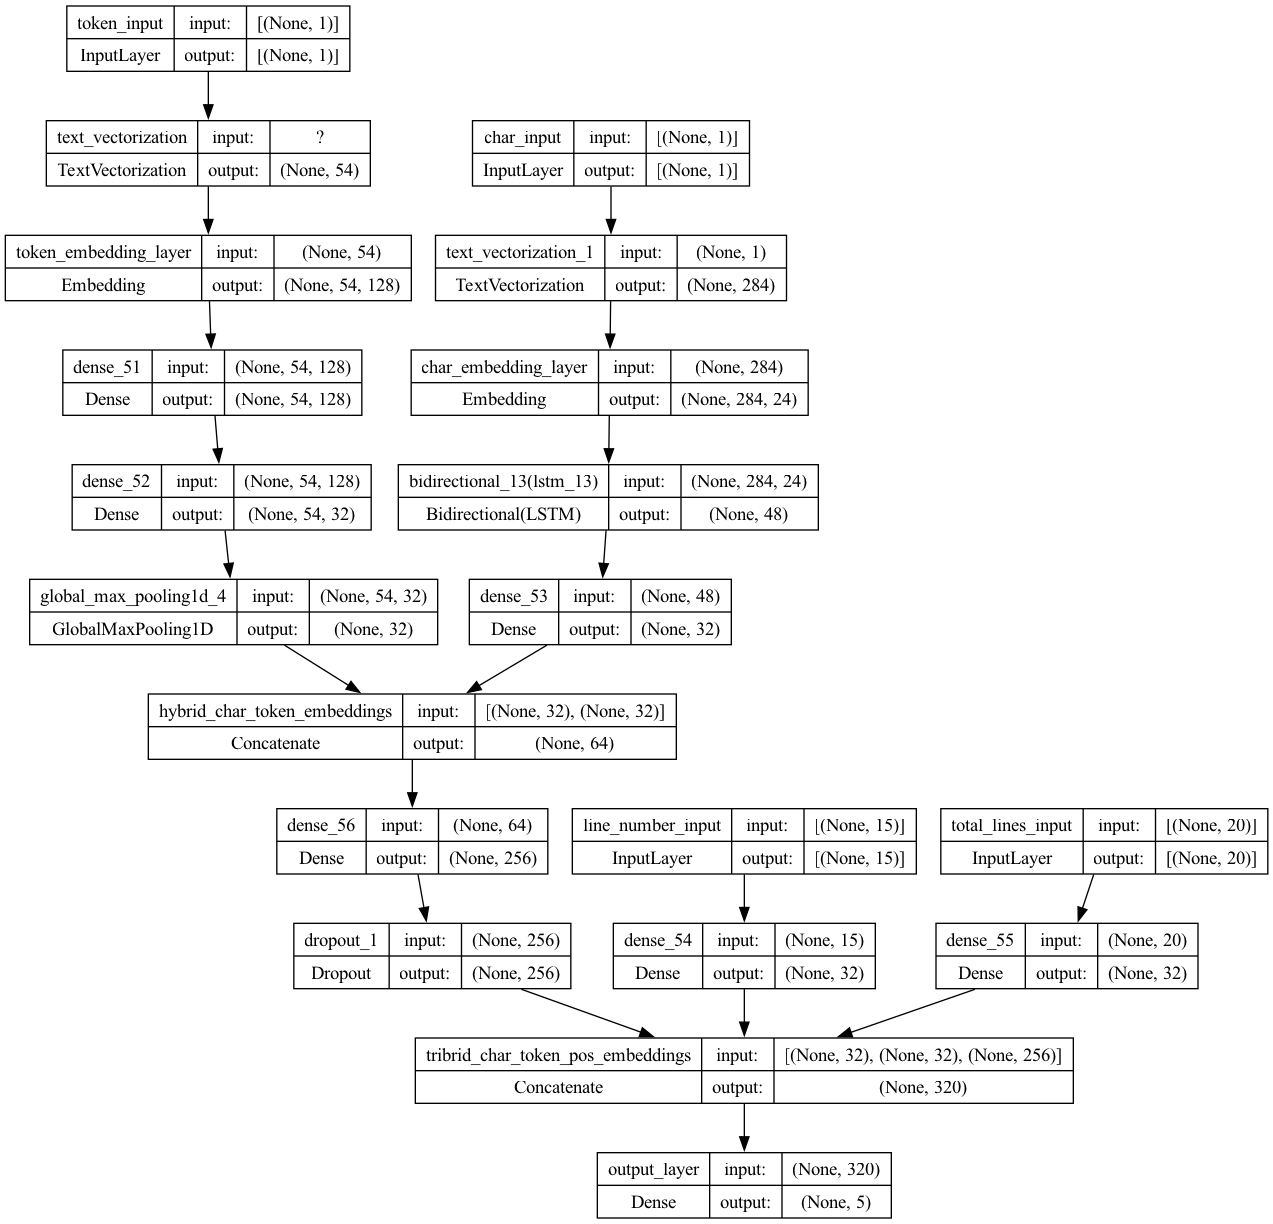

In [65]:
tf.keras.utils.plot_model(model=model_large, to_file='skimlit_model_large.png', show_shapes=True)

In [66]:
model_large.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy']
)

### Fitting the Large Model

In [67]:
history_large = model_large.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
6912/6912 [==============================] - 535s 76ms/step - loss: 0.9341 - accuracy: 0.8346 - val_loss: 0.9026 - val_accuracy: 0.8611
Epoch 2/3
6912/6912 [==============================] - 415s 60ms/step - loss: 0.8976 - accuracy: 0.8611 - val_loss: 0.8956 - val_accuracy: 0.8681
Epoch 3/3
6912/6912 [==============================] - 418s 61ms/step - loss: 0.8937 - accuracy: 0.8642 - val_loss: 0.8857 - val_accuracy: 0.8684


### Evaluating the Large Model

In [68]:
model_large.evaluate(valid_dataset)

905/905 [==============================] - 10s 11ms/step - loss: 0.8780 - accuracy: 0.8713


[0.8780325651168823, 0.8713189363479614]

In [70]:
model_large_pred_probs = model_large.predict(test_dataset)
model_large_pred_probs

922/922 [==============================] - 9s 10ms/step


array([[0.6416472 , 0.04517417, 0.0077225 , 0.28985614, 0.01559999],
       [0.54528356, 0.05664951, 0.05924479, 0.24628434, 0.09253791],
       [0.43628037, 0.10604442, 0.06779546, 0.34233543, 0.04754429],
       ...,
       [0.02437647, 0.09580749, 0.03218653, 0.02708866, 0.82054085],
       [0.03897727, 0.8286919 , 0.02853928, 0.02836994, 0.0754215 ],
       [0.03614338, 0.84157014, 0.0104118 , 0.03001793, 0.08185676]],
      dtype=float32)

In [71]:
model_large_preds = tf.argmax(model_large_pred_probs, axis=1)
model_large_preds

<tf.Tensor: shape=(29493,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [72]:
model_large_results = calculate_results(
    y_true=test_labels_encoded,
    y_pred=model_large_preds
)
model_large_results

{'accuracy': 87.06811785847489,
 'precision': 0.8733173372793755,
 'recall': 0.8706811785847489,
 'f1': 0.8683686988223301}

### Saving the Large Model

In [73]:
model_large.save('skimlit_model_large.keras')

### Evaluating on Custom Example Data

Get more abstract data from here: https://pubmed.ncbi.nlm.nih.gov/

In [74]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2024-01-29 22:20:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: 'skimlit_example_abstracts.json'

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-01-29 22:20:53 (13.9 MB/s) - 'skimlit_example_abstracts.json' saved [6737/6737]



In [78]:
import json

with open('skimlit_example_abstracts.json') as file:
    example_data = json.load(file)

print(json.dumps(example_data, indent=2))

[
  {
    "abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.",
    "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/",
    "details": "RCT o

In [154]:
def prep_abstract_and_predict(model, abstract_text):
    """Takes in the raw abstract text and the SkimLit model and
    returns a DataFrame consisting of each line and its prediction.
    """
    abstract_sentences = abstract_text.split('. ')
    abstract_chars = [split_chars(sentence) for sentence in abstract_sentences]
    abstract_line_numbers = np.array(range(len(abstract_sentences)))
    abstract_total_lines = np.ones(len(abstract_line_numbers)) * len(abstract_line_numbers)
    dummy_labels = tf.one_hot(np.random.randint(
        low=0,
        high=num_classes,
        size=len(abstract_line_numbers)
    ), depth=5)

    abstract_dataset = Dataset.zip(
        Dataset.from_tensor_slices((
            tf.one_hot(abstract_line_numbers, depth=15),
            tf.one_hot(abstract_total_lines, depth=20),
            abstract_sentences,
            abstract_chars
        )),
        Dataset.from_tensor_slices(dummy_labels)
    ).batch(32).prefetch(AUTOTUNE)
    
    pred_probs = model.predict(abstract_dataset)
    preds = tf.argmax(pred_probs, axis=1)
    
    abstract_df = pd.DataFrame({
        'total_lines': abstract_total_lines,
        'line_number': abstract_line_numbers,
        'text': abstract_sentences,
        'prediction': [(
            'OBJECTIVE',
            'METHODS',
            'RESULTS',
            'CONCLUSIONS',
            'BACKGROUND'
        )[pred] for pred in preds],
        'probability': tf.reduce_max(pred_probs, axis=1)
    })

    return abstract_df

In [155]:
example_data[0]['abstract']

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [156]:
prep_abstract_and_predict(
    model=model_large,
    abstract_text=example_data[0]['abstract']
)

1/1 [==============================] - 0s 20ms/step


,total_lines,line_number,text,prediction,probability
0,8.0,0,This RCT examined the efficacy of a manualized...,CONCLUSIONS,0.484745
1,8.0,1,Participants were randomly assigned to treatme...,RESULTS,0.767730
2,8.0,2,Treatment included instruction and therapeutic...,RESULTS,0.763824
3,8.0,3,A response-cost program was applied to reduce ...,RESULTS,0.583485
4,8.0,4,Significant treatment effects were found for f...,BACKGROUND,0.703371
5,8.0,5,Secondary measures based on staff ratings (tre...,BACKGROUND,0.777936
6,8.0,6,"High levels of parent, child and staff satisfa...",BACKGROUND,0.782982
7,8.0,7,Standardized effect size estimates were primar...,BACKGROUND,0.839103


In [150]:
example_data[1]['abstract']

"Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D 

In [148]:
prep_abstract_and_predict(
    model=model_large,
    abstract_text=example_data[1]['abstract']
)

1/1 [==============================] - 0s 23ms/step


,total_lines,line_number,text,prediction,probability
0,10.0,0,Postpartum depression (PPD) is the most preval...,OBJECTIVE,0.652060
1,10.0,1,"No single cause of PPD has been identified, ho...",OBJECTIVE,0.677631
2,10.0,2,Three nutritional interventions have drawn par...,OBJECTIVE,0.439344
3,10.0,3,We searched for meta-analyses of randomised co...,RESULTS,0.563533
4,10.0,4,Fish oil: Eleven RCT's of prenatal fish oil su...,BACKGROUND,0.320092
5,10.0,5,"Vitamin D: no relevant RCT's were identified, ...",BACKGROUND,0.762319
6,10.0,6,Diet: Two Australian RCT's with dietary advice...,BACKGROUND,0.393382
7,10.0,7,"With the exception of fish oil, few RCT's with...",METHODS,0.424230
8,10.0,8,Further research is needed to determine whethe...,METHODS,0.697098
9,10.0,9,Given the prevalence of PPD and ease of admini...,METHODS,0.777082
